In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("SMSSpamCollection",sep='\t',names=['label','message'])

In [6]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [10]:
df['message_length'] = df['message'].apply(len)

In [12]:
df['message_length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: message_length, dtype: float64

<AxesSubplot: ylabel='Frequency'>

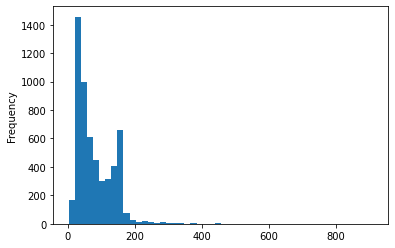

In [13]:
df['message_length'].plot(bins=50,kind='hist')

In [14]:
import seaborn as sns

<AxesSubplot: xlabel='message_length', ylabel='Density'>

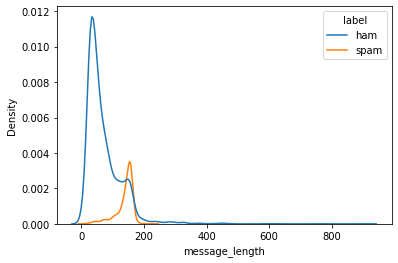

In [17]:
sns.kdeplot(df,x='message_length',hue='label')

<AxesSubplot: xlabel='label', ylabel='message_length'>

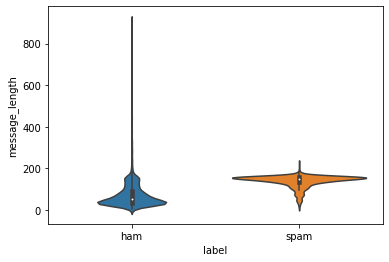

In [43]:
sns.violinplot(df,x='label',y='message_length')

In [24]:
for _,x in df.groupby('label'):
    print(x['message'].iloc[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


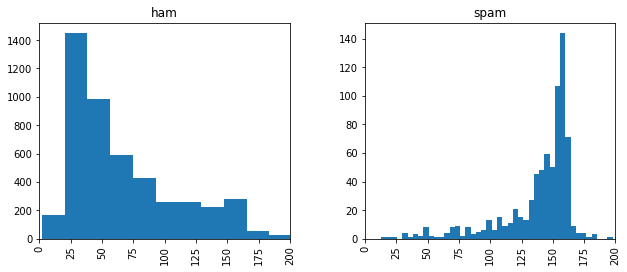

In [50]:
for arr in df.hist(column='message_length', by='label', bins=50,figsize=(10,4)):
        arr.set_xlim((0,200))

In [54]:
import re

In [91]:
from nltk.corpus import stopwords
def process_text_and_tokenize_text(s):
    
    filtered_chars = re.findall('[\w\s]',s)
    filtered_text = "".join(filtered_chars)
    #print(filtered_text)

    return [word for word in filtered_text.split() if word not in stopwords.words('english')]


In [93]:
from sklearn.feature_extraction.text import CountVectorizer


In [94]:
bow_transformer = CountVectorizer(analyzer=process_text_and_tokenize_text).fit(df['message'])

In [95]:
len(df['message'])

5572

In [96]:
len(bow_transformer.vocabulary_)

11531

In [97]:
s = df['message'].iloc[4]

In [98]:
type(s),s

(str, "Nah I don't think he goes to usf, he lives around here though")

In [99]:
bow4 = bow_transformer.transform([s])
print(bow4)
print(bow4.shape)

  (0, 2387)	1
  (0, 3065)	1
  (0, 4983)	1
  (0, 6320)	1
  (0, 7071)	1
  (0, 8023)	1
  (0, 10611)	1
  (0, 10628)	1
  (0, 10977)	1
(1, 11531)


In [102]:
print(bow_transformer.get_feature_names()[10611])
print(bow_transformer.get_feature_names()[10628])

think
though


In [103]:
messages_bow = bow_transformer.transform(df['message'])

In [104]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

Shape of Sparse Matrix:  (5572, 11531)
Amount of Non-Zero occurences:  56002
sparsity: 0.09%


In [105]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 10977)	0.39797532425837473
  (0, 10628)	0.3506110938393669
  (0, 10611)	0.26779388434542895
  (0, 8023)	0.44138920610400284
  (0, 7071)	0.3506110938393669
  (0, 6320)	0.23691324198256786
  (0, 4983)	0.3073900731382254
  (0, 3065)	0.39797532425837473
  (0, 2387)	0.142198689402748


In [107]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


In [108]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11531)


In [110]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, df['label'])

In [112]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', df.label[3])

predicted: ham
expected: ham


In [113]:
all_predictions = spam_detect_model.predict(messages_tfidf)


In [115]:
from sklearn.metrics import classification_report
print(classification_report(df['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In [117]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(df['message'], df['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [118]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text_and_tokenize_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [119]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text_and_tokenize_text at 0x7fd1378dd280>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [120]:
predictions = pipeline.predict(msg_test)


In [121]:
print(classification_report(predictions,label_test))


              precision    recall  f1-score   support

         ham       1.00      0.95      0.97      1004
        spam       0.69      1.00      0.82       111

    accuracy                           0.96      1115
   macro avg       0.85      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115

